### Preamble

In [ ]:
# check if this instance of the notebook already has files present
# and thus determine which steps required prior to reading in file and handling the data
!ls

sample_data


In [ ]:
# set-up spark (NB if Apache amend versions on download site we will need to amend path in wget command)
## NOTE that this version would make use of Hadoop if installed BUT that HDFS & Hadoop is not installed on our Colab
## (we are only using a single node (probably as a VM) so we will not be able to benefit from parallelism)
!clear
!echo welcome

!rm -f spark-3.3.[01]-bin-hadoop3.tgz* 
!rm -rf spark-3.3.[01]-bin-hadoop3

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar -xf spark-3.3.2-bin-hadoop3.tgz

!ls -alt
print("standalone Spark is now installed")

welcome
--2023-05-26 05:35:40--  https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.95.219, 2a01:4f8:10a:201a::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz’

spark-3.3.2-bin-had 100%[===================>] 285.49M  12.1MB/s    in 24s     

2023-05-26 05:36:05 (11.9 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]

total 292368
drwxr-xr-x  1 root root      4096 May 26 05:36 .
drwxr-xr-x  1 root root      4096 May 26 05:30 ..
drwxr-xr-x  1 root root      4096 May 24 18:33 sample_data
drwxr-xr-x  4 root root      4096 May 24 18:32 .config
-rw-r--r--  1 root root 299360284 Feb 10 21:28 spark-3.3.2-bin-hadoop3.tgz
drwxr-xr-x 13  501 1000      4096 Feb 10 20:40 spark-3.3.2-bin-hadoop3
stan

In [ ]:
# init spark (ensure SPARK_HOME set to same version as we download earlier)
!pip3 install findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
# the next line gives us 'local' mode. try 'local[2]' to use 2 cores or 'master:NNNN' to run on Spark standalone cluster at port NNNN
spark_conf = SparkConf().setMaster('local[2]').setAppName('MyApp')
sc = SparkContext(conf=spark_conf)
# see what we have by examining the Spark User Interface
from pyspark.sql import *
from pyspark.sql.functions import *
SparkSession.builder.getOrCreate()
## 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# get file for given year from TfL open data
!wget https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
!unzip cyclehireusagestats-2014.zip

--2023-05-26 05:36:20--  https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
Resolving cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)... 104.16.100.13, 104.16.101.13
Connecting to cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)|104.16.100.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225215129 (215M) [application/zip]
Saving to: ‘cyclehireusagestats-2014.zip’

cyclehireusagestats 100%[===================>] 214.78M   272MB/s    in 0.8s    

2023-05-26 05:36:22 (272 MB/s) - ‘cyclehireusagestats-2014.zip’ saved [225215129/225215129]

Archive:  cyclehireusagestats-2014.zip
  inflating: 1. Journey Data Extract 05Jan14-02Feb14.csv  
  inflating: 10a. Journey Data Extract 14Sep14-27Sep14.csv  
  inflating: 10b. Journey Data Extract 28Sep14-11Oct14.csv  
  inflating: 11a. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 11b. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 12a. Journey Data Extract 09Nov14-06Dec14.csv  
  i

After unzipping the dataset, it was noted that the dataset is in different CSV files mostly according to month. We will therefore load the dataset according to season (autumn and spring), the month in autumn being September, October November and the first half of December while the months in spring are March, April, May and first half of June


In [ ]:
#Read and load the csv dataset into dataframe using Spark (autumn)
sep1="./10a. Journey*csv"
sep2="./10b. Journey*csv"
oct="./11a. Journey*csv"
oct1="./11b. Journey*csv"
nov="./12a. Journey*csv"
nov2="./12b. Journey*csv"
dec="./13a. Journey*csv"
spark = SparkSession.builder.appName("bikes").getOrCreate()
aut_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load([sep1, sep2, oct, oct1, nov, nov2, dec]))
# sep1_df = sep1_df.drop(*[c for c in sep1_df.columns if sep1_df.select(c).na.drop().count() == 0])

# Alternatively, you can also use the following syntax:
# sep2_df = sep2_df.dropna(how='all', thresh=None)
aut_df.show()

+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+----+----+----+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name| _c9|_c10|_c11|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+----+----+----+
| 37875851|     120|   3229|28/09/2014 00:02|          450|Jubilee Street, S...|28/09/2014 00:00|            443|Philpot Street, W...|null|null|null|
| 37875861|    1080|   3283|28/09/2014 00:18|          645|Great Suffolk Str...|28/09/2014 00:00|             14|Belgrove Street ,...|null|null|null|
| 37875857|    2820|  11369|28/09/2014 00:47|          727|Chesilton Road, F...|28/09/2014 00:00|            321|Bermondsey Street...|null|null|null|
| 37875849|    1620|  11362|28/09/2014 00:27|          719|Victoria Park Roa...|28/09/2014 00:00|   

In [ ]:
#Read and load the csv dataset into dataframe using Spark (spring)
mar="./3. Journey*csv"
apr="./4. Journey*csv"
apr2="./5. Journey*csv"
may="./6. Journey*csv"
spark = SparkSession.builder.appName("bikes").getOrCreate()
sprg_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load([mar, apr, apr2, may]))

# sprg_df = sprg_df.drop(*[c for c in sprg_df.columns if sprg_df.select(c).na.drop().count() == 0])


# Alternatively, you can also use the following syntax:
# sprg_df = sprg_df.dropna(how='all', thresh=None)
# sprg_df.show()

In [ ]:
# count the number of rows in the dataframe
num_rows = aut_df.count()
print("Number of rows: ", num_rows)

# count the number of columns in the dataframe
num_cols = len(aut_df.columns)
print("Number of columns: ", num_cols)

Number of rows:  3114128
Number of columns:  12


In [ ]:
# count the number of rows in the dataframe
num_rows = sprg_df.count()
print("Number of rows: ", num_rows)

# count the number of columns in the dataframe
num_cols = len(sprg_df.columns)
print("Number of columns: ", num_cols)

Number of rows:  3146046
Number of columns:  12


### Data Preprocessing


In [ ]:
from pyspark.sql.functions import col
#check for null values
aut_df.select([count(when(col(c).isNull(), c)).alias(c) for c in aut_df.columns]).show()
sprg_df.select([count(when(col(c).isNull(), c)).alias(c) for c in sprg_df.columns]).show()

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+-------+-------+-------+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|    _c9|   _c10|   _c11|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+-------+-------+-------+
|   488627|  488627| 488627|  488627|       488657|         488657|    488627|         488627|           488627|3114128|3114128|3114128|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+-------+-------+-------+

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+-------+-------+-------+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|    _c9|   _c10|   _c11|
+---------+--------+-------+--------+---

In [ ]:
#drop the null values
aut_df = aut_df.drop(*[c for c in aut_df.columns if aut_df.select(c).na.drop().count() == 0])
aut_df = aut_df.dropna()
aut_df.select([count(when(col(c).isNull(), c)).alias(c) for c in aut_df.columns]).show()

sprg_df = sprg_df.drop(*[c for c in sprg_df.columns if sprg_df.select(c).na.drop().count() == 0])
sprg_df = sprg_df.dropna()
sprg_df.select([count(when(col(c).isNull(), c)).alias(c) for c in sprg_df.columns]).show()

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|        0|       0|      0|       0|            0|              0|         0|              0|                0|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+
|        0|       0|      0|       0|            0|              0|         0|              0| 

In [ ]:
# random sampling of the dataframe

# Import necessary libraries
from pyspark.sql.functions import rand

# Create a sampled DataFrame with 20% of the original data
s_aut_df = aut_df.sample(fraction=0.2, seed=42)

# Sort the sampled DataFrame by a random column to get a random sample
s_aut_df = s_aut_df.orderBy(rand())

# Show the first 5 rows of the sampled DataFrame
s_aut_df.show(5)


s_sprg_df = sprg_df.sample(fraction=0.2, seed=42)
s_sprg_df = s_sprg_df.orderBy(rand())
s_sprg_df.show(5)


+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|        End Date|EndStation Id|     EndStation Name|      Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+----------------+-------------+--------------------+----------------+---------------+--------------------+
| 38504606|     900|   8272|18/10/2014 11:35|          499|    Furze Green, Bow|18/10/2014 11:20|            722|Finnis Street, Be...|
| 37935550|     240|   1551|29/09/2014 16:57|          403|George Place Mews...|29/09/2014 16:53|            301|Marylebone Lane, ...|
| 38054918|     120|   2065|02/10/2014 19:03|           11|Brunswick Square,...|02/10/2014 19:01|             77|Russell Square St...|
| 38852755|    1140|   3743|29/10/2014 08:43|          348|Grosvenor Square,...|29/10/2014 08:24|            277|Kensington Church...|
| 38970276|     480|   8848|01/11/2014 17:07|          

In [ ]:
# checking for duplicates in the dataset
duplicate = aut_df.groupBy('Rental Id')\
    .count()\
    .filter(col('count') > 1)

duplicate.show()

+---------+-----+
|Rental Id|count|
+---------+-----+
+---------+-----+



In [ ]:
# checking for duplicates in the dataset
duplicate = sprg_df.groupBy(sprg_df.columns)\
    .count()\
    .filter(col('count') > 1)

duplicate.show()

+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+-----+
|Rental Id|Duration|Bike Id|End Date|EndStation Id|EndStation Name|Start Date|StartStation Id|StartStation Name|count|
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+-----+
+---------+--------+-------+--------+-------------+---------------+----------+---------------+-----------------+-----+



Since we don't have any duplicate values, we will go ahead to convert the date to timestamp and convert the duration from seconds to minutes

In [ ]:
from pyspark.sql.functions import to_timestamp
#Convert the date and time columns to timestamp format and calculate the duration of each ride.


aut_df = aut_df.withColumn('Start Date', to_timestamp('Start Date', 'dd/MM/yyyy HH:mm'))
aut_df = aut_df.withColumn('End Date', to_timestamp('End Date', 'dd/MM/yyyy HH:mm'))

sprg_df = sprg_df.withColumn('End Date', to_timestamp('End Date', 'dd/MM/yyyy HH:mm'))
sprg_df = sprg_df.withColumn('Start Date', to_timestamp('Start Date', 'dd/MM/yyyy HH:mm'))


aut_df = aut_df.withColumn('Duration', (aut_df['End Date'].cast('long') - aut_df['Start Date'].cast('long')))

sprg_df = sprg_df.withColumn('Duration', (sprg_df['End Date'].cast('long') - sprg_df['Start Date'].cast('long')))



In [ ]:
from pyspark.sql.functions import month, when
#Add the "Start Month" and "Season" columns to the DataFrame for further analysis.
journey_df = aut_df.union(sprg_df)

journey_df = journey_df.withColumn('Start Month', month(aut_df['Start Date']))


journey_df = journey_df.withColumn('Start Month', month(journey_df['Start Date']))


journey_df = journey_df.withColumn('Season', when((journey_df['Start Date'] >= '2014-03-21 00:00:00') & (journey_df['Start Date'] <= '2014-06-20 23:59:59'), 'Spring')
                                            .when((journey_df['Start Date'] >= '2014-09-21 00:00:00') & (journey_df['Start Date'] <= '2014-12-20 23:59:59'), 'Autumn')
                                            .otherwise('Other'))

journey_df.show(20)





+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|Start Month|Season|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+
| 37875851|     120|   3229|2014-09-28 00:02:00|          450|Jubilee Street, S...|2014-09-28 00:00:00|            443|Philpot Street, W...|          9|Autumn|
| 37875861|    1080|   3283|2014-09-28 00:18:00|          645|Great Suffolk Str...|2014-09-28 00:00:00|             14|Belgrove Street ,...|          9|Autumn|
| 37875857|    2820|  11369|2014-09-28 00:47:00|          727|Chesilton Road, F...|2014-09-28 00:00:00|            321|Bermondsey Street...|          9|Autumn|
| 37875849|    1620|  11362|2014-09-28 0

In [ ]:
from pyspark.sql.functions import sum

from pyspark.sql.functions import col

# # drop the original duration column
# journey_df = journey_df.drop("Duration")

# group by "StartStation Id" and sum their "Duration (min)", sort in descending order
strt_aut_df = (journey_df
               .select("StartStation Id", "StartStation Name", "EndStation Id", "EndStation Name", "Duration")
               .groupBy("StartStation Id", "StartStation Name")
               .agg(sum("Duration").alias("Total Duration"))
               .orderBy("Total Duration", ascending=False))

# show top 10
strt_aut_df.show(10)
# group "StartStation Id" and sum their "Duration" (seconds), sort in descending order




+---------------+--------------------+--------------+
|StartStation Id|   StartStation Name|Total Duration|
+---------------+--------------------+--------------+
|            191|Hyde Park Corner,...|     145642140|
|            307|Black Lion Gate, ...|     108015480|
|            406|Speakers' Corner ...|      91773000|
|            303|Albert Gate, Hyde...|      81858720|
|            213|Wellington Arch, ...|      58655040|
|            407|Speakers' Corner ...|      55465500|
|            404|Palace Gate, Kens...|      54448800|
|             14|Belgrove Street ,...|      50934120|
|            248|Triangle Car Park...|      48876600|
|            553|Regent's Row , Ha...|      46141500|
+---------------+--------------------+--------------+
only showing top 10 rows



In [ ]:
#group by "EndStation Id" and sum their "Duration", sort in descending order
end_aut_df = (journey_df
               .select("StartStation Id", "StartStation Name", "EndStation Id", "EndStation Name", "Duration")
               .groupBy("EndStation Id", "EndStation Name")
               .agg(sum("Duration").alias("Total Duration"))
               .orderBy("Total Duration", ascending=False))
end_aut_df.show()



+-------------+--------------------+--------------+
|EndStation Id|     EndStation Name|Total Duration|
+-------------+--------------------+--------------+
|          191|Hyde Park Corner,...|     122065980|
|          346|Mechanical Worksh...|      90640860|
|          307|Black Lion Gate, ...|      84249300|
|          303|Albert Gate, Hyde...|      76905720|
|          434|Mechanical Worksh...|      71449500|
|          406|Speakers' Corner ...|      69432120|
|           14|Belgrove Street ,...|      55485540|
|          213|Wellington Arch, ...|      49762560|
|          404|Palace Gate, Kens...|      47563260|
|          407|Speakers' Corner ...|      45922680|
|          194|Hop Exchange, The...|      45667860|
|          374|Waterloo Station ...|      44549760|
|          248|Triangle Car Park...|      41360160|
|          553|Regent's Row , Ha...|      39369000|
|          341|Craven Street, St...|      38166420|
|          541|Green Park Statio...|      37461120|
|          3

In [ ]:
from pyspark.sql.functions import col, expr

# Calculate the first and third quartiles and interquartile range
quantiles = journey_df.approxQuantile("Duration", [0.25, 0.75], 0.05)
q1 = quantiles[0]
q3 = quantiles[1]
iqr = q3 - q1

# Calculate the lower and upper bounds for outlier detection
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Count the number of outliers
num_outliers = journey_df.filter(expr(f"Duration < {lower_bound} or Duration > {upper_bound}")).count()
# Print the number of outliers
print("Number of outliers: {0}".format(num_outliers))


Number of outliers: 356034


### Feature Engineering

In [ ]:
journey_df.count()

5771489

In [ ]:
#filtering out rows from the DataFrame that have a season labeled as "Other".
journey_df = journey_df.filter(journey_df['Season'] != 'Other')


In [ ]:
journey_df.show()

+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|Start Month|Season|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+
| 37875851|     120|   3229|2014-09-28 00:02:00|          450|Jubilee Street, S...|2014-09-28 00:00:00|            443|Philpot Street, W...|          9|Autumn|
| 37875861|    1080|   3283|2014-09-28 00:18:00|          645|Great Suffolk Str...|2014-09-28 00:00:00|             14|Belgrove Street ,...|          9|Autumn|
| 37875857|    2820|  11369|2014-09-28 00:47:00|          727|Chesilton Road, F...|2014-09-28 00:00:00|            321|Bermondsey Street...|          9|Autumn|
| 37875849|    1620|  11362|2014-09-28 0

In [ ]:
from pyspark.sql import functions as F
#calculating and displaying the count of bike ride for each start month
month_count = journey_df.groupBy("Start Month").agg(F.count("*").alias("count")).orderBy("Start Month")
month_count.show()


+-----------+------+
|Start Month| count|
+-----------+------+
|          3|251809|
|          4|796415|
|          5|880040|
|          6|697826|
|          9|346460|
|         10|896038|
|         11|705834|
|         12|417595|
+-----------+------+



In [ ]:
from pyspark.sql.functions import date_format
#adding a column "day" representing the day of the week that corresponds to the start date
journey_df = journey_df.withColumn('Day', date_format('Start Date', 'EEEE'))
journey_df.show()


+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|Start Month|Season|   Day|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+------+
| 37875851|     120|   3229|2014-09-28 00:02:00|          450|Jubilee Street, S...|2014-09-28 00:00:00|            443|Philpot Street, W...|          9|Autumn|Sunday|
| 37875861|    1080|   3283|2014-09-28 00:18:00|          645|Great Suffolk Str...|2014-09-28 00:00:00|             14|Belgrove Street ,...|          9|Autumn|Sunday|
| 37875857|    2820|  11369|2014-09-28 00:47:00|          727|Chesilton Road, F...|2014-09-28 00:00:00|            321|Bermondsey Street...|          9|Autumn|Sunday

In [ ]:
journey_df.filter(journey_df['Day'] == 'Sunday').show()

+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|Start Month|Season|   Day|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+------+
| 37875851|     120|   3229|2014-09-28 00:02:00|          450|Jubilee Street, S...|2014-09-28 00:00:00|            443|Philpot Street, W...|          9|Autumn|Sunday|
| 37875861|    1080|   3283|2014-09-28 00:18:00|          645|Great Suffolk Str...|2014-09-28 00:00:00|             14|Belgrove Street ,...|          9|Autumn|Sunday|
| 37875857|    2820|  11369|2014-09-28 00:47:00|          727|Chesilton Road, F...|2014-09-28 00:00:00|            321|Bermondsey Street...|          9|Autumn|Sunday

In [ ]:
#Display the ride count by day in spring
springs_df = journey_df.filter(journey_df.Season =='Spring')

In [ ]:
#Display the ride count by day in Autumn
Autumns_df = journey_df.filter(journey_df.Season =='Autumn')

In [ ]:
# # Feature engineering to create another column for duration in days
# journey_df = journey_df.withColumn('Duration_days', journey_df['Duration'] / 1440)
# journey_df.show()

In [ ]:
from pyspark.sql.functions import min, max

# Calculate the maximum duration for each start station in the Autumn DataFrame
max_dur = journey_df.groupBy("StartStation Name").agg(max("Duration").alias("max_duration"))

# Calculate the minimum duration for each start station in the Autumn DataFrame
min_dur = journey_df.groupBy("StartStation Name").agg(min("Duration").alias("min_duration"))




In [ ]:
min_dur.show()

+--------------------+------------+
|   StartStation Name|min_duration|
+--------------------+------------+
|Dunston Road , Ha...|           0|
|Panton Street, We...|       -1260|
|George Place Mews...|           0|
|Russell Gardens, ...|           0|
|Montgomery Square...|           0|
|  Park Lane, Mayfair|           0|
|Portland Place, M...|           0|
|Appold Street, Li...|           0|
|Kingsway Southbou...|           0|
|Gloucester Street...|           0|
|Embankment (Horse...|        -540|
|Cadogan Close, Vi...|       -2400|
|Charlotte Street,...|           0|
|Lambeth Road, Vau...|           0|
|London Zoo, Regen...|           0|
|Falcon Road, Clap...|           0|
|Christopher Stree...|           0|
|Imperial Road, Sa...|           0|
|Finlay Street, Fu...|           0|
|Queen Marys, Mile...|           0|
+--------------------+------------+
only showing top 20 rows



In [ ]:
max_dur.show()

+--------------------+------------+
|   StartStation Name|max_duration|
+--------------------+------------+
|Dunston Road , Ha...|      883620|
|Panton Street, We...|     1013880|
|George Place Mews...|       71280|
|Russell Gardens, ...|      436560|
|Montgomery Square...|       88380|
|  Park Lane, Mayfair|      693480|
|Portland Place, M...|      582300|
|Appold Street, Li...|       62940|
|Kingsway Southbou...|      515520|
|Gloucester Street...|     1124640|
|Embankment (Horse...|      289380|
|Cadogan Close, Vi...|     1883880|
|Charlotte Street,...|      366900|
|Lambeth Road, Vau...|       36720|
|London Zoo, Regen...|      609840|
|Falcon Road, Clap...|      415860|
|Christopher Stree...|      847800|
|Imperial Road, Sa...|      862680|
|Finlay Street, Fu...|      827400|
|Queen Marys, Mile...|     1174320|
+--------------------+------------+
only showing top 20 rows



In [ ]:
#perform inner-join based on start station name
agg_df= max_dur.join(min_dur, ['StartStation Name'], 'inner')
agg_df.show()

+--------------------+------------+------------+
|   StartStation Name|max_duration|min_duration|
+--------------------+------------+------------+
|Dunston Road , Ha...|      883620|           0|
|Panton Street, We...|     1013880|       -1260|
|George Place Mews...|       71280|           0|
|Russell Gardens, ...|      436560|           0|
|Montgomery Square...|       88380|           0|
|  Park Lane, Mayfair|      693480|           0|
|Portland Place, M...|      582300|           0|
|Appold Street, Li...|       62940|           0|
|Kingsway Southbou...|      515520|           0|
|Gloucester Street...|     1124640|           0|
|Embankment (Horse...|      289380|        -540|
|Cadogan Close, Vi...|     1883880|       -2400|
|Charlotte Street,...|      366900|           0|
|Lambeth Road, Vau...|       36720|           0|
|London Zoo, Regen...|      609840|           0|
|Falcon Road, Clap...|      415860|           0|
|Christopher Stree...|      847800|           0|
|Imperial Road, Sa..

In [ ]:
journey_df.show()

+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|Start Month|Season|   Day|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+------+
| 37875851|     120|   3229|2014-09-28 00:02:00|          450|Jubilee Street, S...|2014-09-28 00:00:00|            443|Philpot Street, W...|          9|Autumn|Sunday|
| 37875861|    1080|   3283|2014-09-28 00:18:00|          645|Great Suffolk Str...|2014-09-28 00:00:00|             14|Belgrove Street ,...|          9|Autumn|Sunday|
| 37875857|    2820|  11369|2014-09-28 00:47:00|          727|Chesilton Road, F...|2014-09-28 00:00:00|            321|Bermondsey Street...|          9|Autumn|Sunday

In [ ]:
from pyspark.sql.functions import from_utc_timestamp

# Adjust the hour for daylight saving time
df = journey_df.withColumn('Hour_DST', hour(from_utc_timestamp('Start Date', 'PST8PDT')))
# Filter the DataFrame to show cases affected by daylight saving
daylight_saving = df.filter((col('Hour_DST') == 1) | (col('Hour_DST') == 2))
daylight_saving.show()


+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+------+--------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|Start Month|Season|   Day|Hour_DST|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+------+--------+
| 37879870|    1140|   7221|2014-09-28 08:19:00|          374|Waterloo Station ...|2014-09-28 08:00:00|            574|Eagle Wharf Road,...|          9|Autumn|Sunday|       1|
| 37879871|    1140|  12542|2014-09-28 08:19:00|          374|Waterloo Station ...|2014-09-28 08:00:00|            574|Eagle Wharf Road,...|          9|Autumn|Sunday|       1|
| 37879863|     180|  11166|2014-09-28 08:03:00|          492|The Green Bridge,...|2014-09-28 08:00:00|            531|T

In [ ]:
daylight_saving = daylight_saving.withColumn('adj_dur_min', (col('duration') + 3600) / 60)
daylight_saving.show()


+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+------+--------+-----------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|Start Month|Season|   Day|Hour_DST|adj_dur_min|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+------+--------+-----------+
| 37879870|    1140|   7221|2014-09-28 08:19:00|          374|Waterloo Station ...|2014-09-28 08:00:00|            574|Eagle Wharf Road,...|          9|Autumn|Sunday|       1|       79.0|
| 37879871|    1140|  12542|2014-09-28 08:19:00|          374|Waterloo Station ...|2014-09-28 08:00:00|            574|Eagle Wharf Road,...|          9|Autumn|Sunday|       1|       79.0|
| 37879863|     180|  11166|2014-09-28 08:03:00|          49

In [ ]:
filtered_j_df = journey_df.filter(journey_df.Duration >= 4320).select('Duration')
print((filtered_j_df.count(), len(filtered_j_df.columns)))



(131857, 1)


### Data Exploration

<Axes: xlabel='season'>

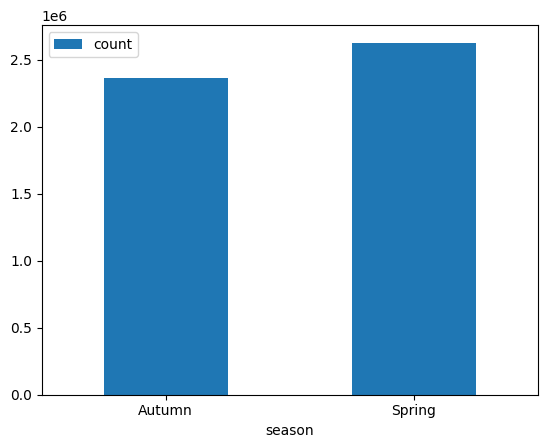

In [ ]:
# group the data by season and count the number of rentals in each season
season_counts_df = journey_df.groupBy('season').count()

# plot a bar chart of the rental counts by season
season_counts_df.toPandas().plot(kind='bar', x='season', y='count', rot=0)

From the graph above, we can deduce that the number of rides during spring is higher than in Autumn

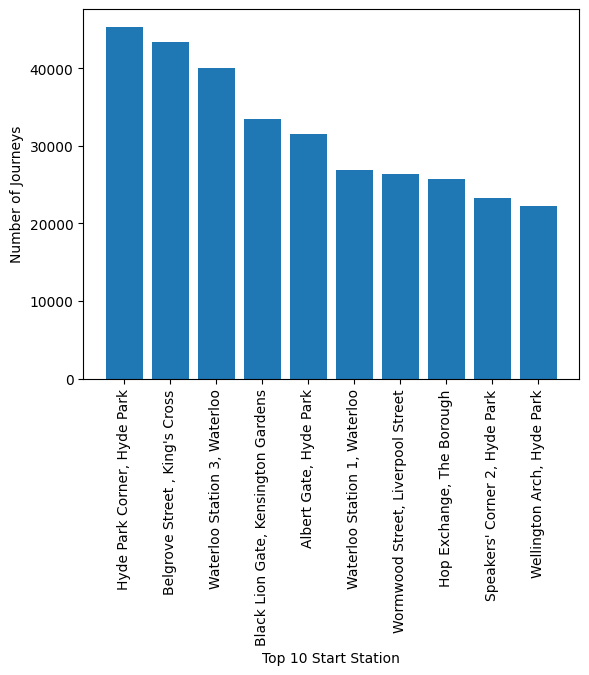

In [ ]:
from pyspark.sql.functions import desc

# Count the number of times each start station appears
start_station_counts = journey_df.groupBy("StartStation Name").count()

# Sort the stations by count in descending order
sorted_stations = start_station_counts.orderBy(desc("count"))

# Take the top 10 stations with the most counts
top_stations = sorted_stations.limit(10)

# Convert the top 10 stations to a Pandas dataframe for plotting
pandas_df = top_stations.toPandas()

# Plot a bar chart of the top 10 stations
import matplotlib.pyplot as plt

plt.bar(pandas_df["StartStation Name"], pandas_df["count"])
plt.xticks(rotation=90)
plt.xlabel("Top 10 Start Station")
plt.ylabel("Number of Journeys")
plt.show()


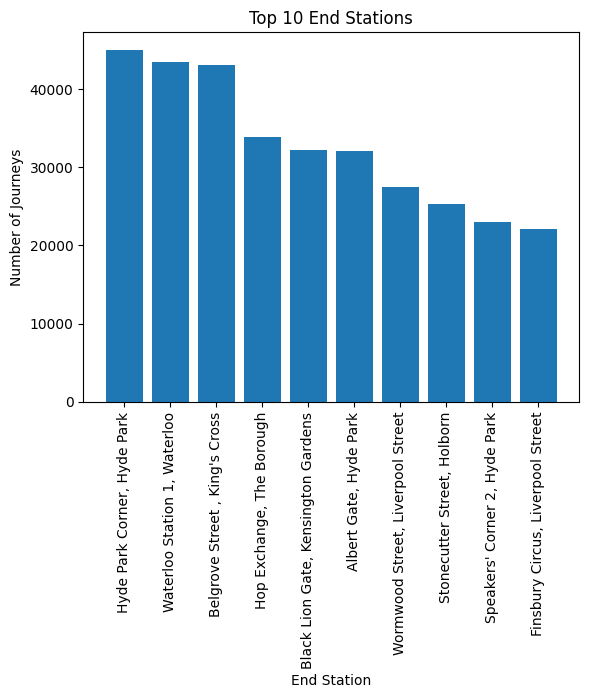

In [ ]:
import matplotlib.pyplot as plt

# Group by End Station and count occurrences
end_station_counts = journey_df.groupBy('EndStation Name').count()
sorted_end =end_station_counts.orderBy(desc("count"))


# Get the top 10 stations with the highest counts
top_end_stations = sorted_end.limit(10)

# Extract station names and counts
pandend_df=top_end_stations.toPandas()

# Plot bar chart
plt.bar(pandend_df["EndStation Name"], pandend_df["count"])
plt.xticks(rotation=90)
plt.title('Top 10 End Stations')
plt.xlabel('End Station')
plt.ylabel('Number of Journeys')
plt.show()


In [ ]:
from pyspark.sql.functions import desc

top20_df = journey_df.orderBy(desc('Duration')).limit(100)
top20_df.show()


+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+--------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|Start Month|Season|     Day|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+--------+
| 33205564| 2564700|    722|2014-06-23 18:10:00|          253|Shoreditch Park, ...|2014-05-25 01:45:00|            401|Columbia Road, We...|          5|Spring|  Sunday|
| 33219946| 2503620|   4534|2014-06-23 14:23:00|          346|Mechanical Worksh...|2014-05-25 14:56:00|            292|Montpelier Street...|          5|Spring|  Sunday|
| 39899855| 2460120|    962|2015-01-07 07:22:00|          595|Hammersmith Road,...|2014-12-09 20:00:00|            619|Irene Road, Parso...|         12|Aut

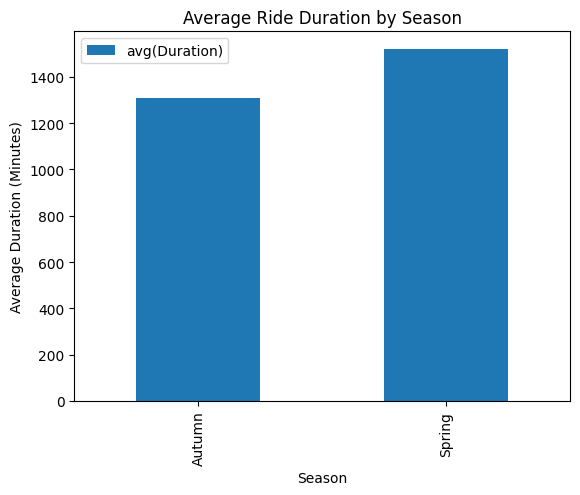

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter the DataFrame to include only autumn and spring seasons
autumn_spring_df = journey_df.filter("Season IN ('Autumn', 'Spring')")

# Filter out rides with duration of 0 mins or over 3600 mins
grouped_df = autumn_spring_df.groupby("Season").mean().select("Season", "avg(Duration)")

# Convert the Spark DataFrame to a Pandas DataFrame
pdf = grouped_df.toPandas()

# Create a bar plot of the average duration of rides for each season
pdf.plot(kind="bar", x="Season", y="avg(Duration)")

# Set the title and axis labels
plt.title("Average Ride Duration by Season")
plt.xlabel("Season")
plt.ylabel("Average Duration (Minutes)")

# Show the plot
plt.show()


In [ ]:
journey_df.select('Season').distinct().show()

+------+
|Season|
+------+
|Autumn|
|Spring|
+------+



In [ ]:
journey_df.select('Duration').count()

4992017

In [ ]:
# Select the duration column for autumn and spring seasons
autumn_df = journey_df.filter(journey_df['Season'] == 'Autumn').select('Duration')
spring_df = journey_df.filter(journey_df['Season'] == 'Spring').select('Duration')

# Compute the mean and standard deviation of the duration column for each season
autumn_stats = autumn_df.agg(avg(col("Duration")).alias("mean"), stddev(col("Duration")).alias("stddev")).collect()[0]
spring_stats = spring_df.agg(avg(col("Duration")).alias("mean"), stddev(col("Duration")).alias("stddev")).collect()[0]

# Print the results
print("Autumn mean duration:", autumn_stats["mean"])
print("Autumn duration standard deviation:", autumn_stats["stddev"])
print("Spring mean duration:", spring_stats["mean"])
print("Spring duration standard deviation:", spring_stats["stddev"])

Autumn mean duration: 1310.1177762458435
Autumn duration standard deviation: 13119.895072129673
Spring mean duration: 1520.4296882437388
Spring duration standard deviation: 12540.683023734864


In [ ]:
autumn_df.show()

+--------+
|Duration|
+--------+
|     120|
|    1080|
|    2820|
|    1620|
|     480|
|    1080|
|    1380|
|    3060|
|    3060|
|    9600|
|    1560|
|    1080|
|     660|
|     300|
|    1620|
|     300|
|    1740|
|     720|
|    1020|
|    1020|
+--------+
only showing top 20 rows



In [ ]:
#calculate the minimum and maximum durations of bike rides for each start station in the 'journey_df' dataframe
max_J_df = journey_df.groupby("StartStation Name").agg({"Duration": "max"})
min_J_df = journey_df.groupby("StartStation Name").agg({"Duration": "min"})

min_J_df.show()

+--------------------+-------------+
|   StartStation Name|min(Duration)|
+--------------------+-------------+
|Dunston Road , Ha...|            0|
|Panton Street, We...|        -1260|
|George Place Mews...|            0|
|Russell Gardens, ...|            0|
|Montgomery Square...|            0|
|  Park Lane, Mayfair|            0|
|Portland Place, M...|            0|
|Appold Street, Li...|            0|
|Kingsway Southbou...|            0|
|Gloucester Street...|            0|
|Embankment (Horse...|         -540|
|Cadogan Close, Vi...|        -2400|
|Charlotte Street,...|            0|
|Lambeth Road, Vau...|            0|
|London Zoo, Regen...|            0|
|Falcon Road, Clap...|            0|
|Christopher Stree...|            0|
|Imperial Road, Sa...|            0|
|Finlay Street, Fu...|            0|
|Queen Marys, Mile...|            0|
+--------------------+-------------+
only showing top 20 rows



In [ ]:
import pyspark.sql.functions as F

# Group by season and calculate the average duration of rentals for each season
rentals_by_season = journey_df.groupBy('Season').agg(F.avg('Duration').alias('Avg Duration'))

# Show the results
rentals_by_season.show()


+------+------------------+
|Season|      Avg Duration|
+------+------------------+
|Autumn|1310.1177762458435|
|Spring|1520.4296882437388|
+------+------------------+



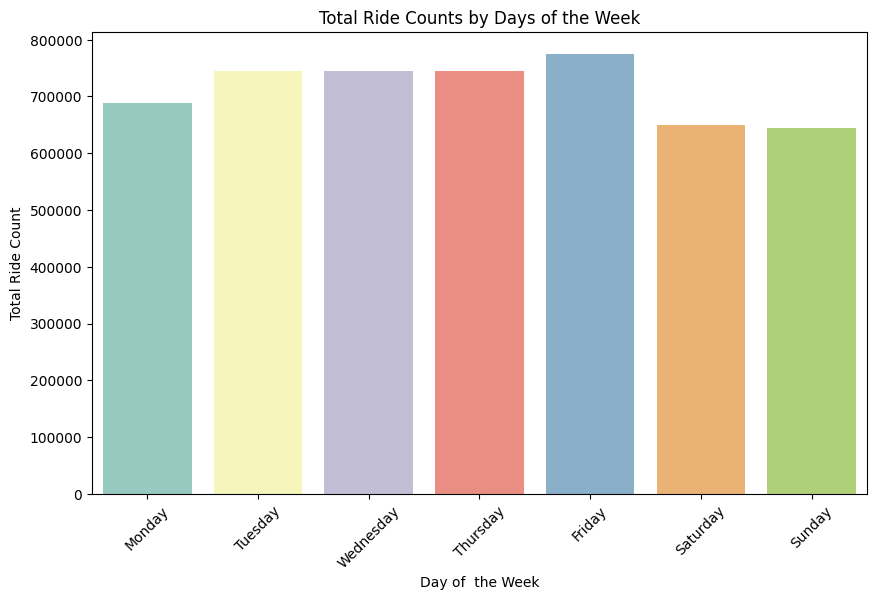

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#Ride count by day for the dataframe
# Register the DataFrame as a temporary view
journey_df.createOrReplaceTempView("rides")

# Query the DataFrame to calculate the ride counts by day of the week
query = """
    SELECT Day, COUNT(*) AS count
    FROM rides
    GROUP BY Day
    ORDER BY Day
"""
ride_counts_per_day = spark.sql(query)

# Convert the resulting DataFrame to a Pandas DataFrame for plotting
ride_counts_pd = ride_counts_per_day.toPandas()

# Define the order of the days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Set a custom color palette
colors = sns.color_palette('Set3', len(days))

# Create a bar plot 
plt.figure(figsize=(10, 6))
sns.barplot(x='Day', y='count', data=ride_counts_pd, order=days, palette=colors)
plt.title('Total Ride Counts by Days of the Week')
plt.xlabel('Day of  the Week')
plt.ylabel('Total Ride Count')
plt.xticks(rotation=45)
plt.show()


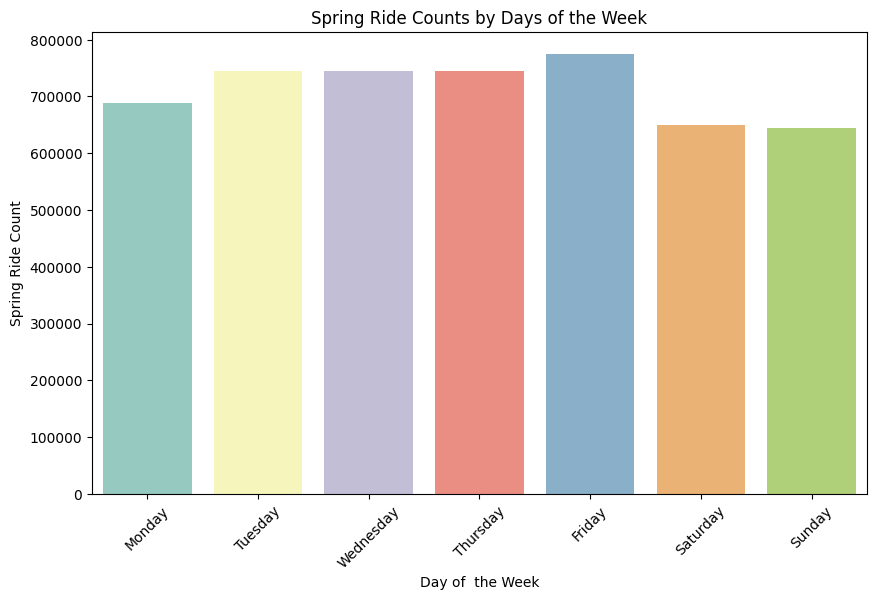

In [ ]:
#Ride count by day for spring
# Register the DataFrame as a temporary view
springs_df.createOrReplaceTempView("rides")

# Query the DataFrame to calculate the ride counts by day of the week
query = """
    SELECT Day, COUNT(*) AS count
    FROM rides
    GROUP BY Day
    ORDER BY Day
"""
ride_counts_pd_sprg = spark.sql(query)

# Convert the resulting DataFrame to a Pandas DataFrame for plotting
ride_counts_pd_sprg = ride_counts_pd_sprg.toPandas()

# Define the order of the days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Set a custom color palette
colors = sns.color_palette('Set3', len(days))

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Day', y='count', data=ride_counts_pd, order=days, palette=colors)
plt.title('Spring Ride Counts by Days of the Week')
plt.xlabel('Day of  the Week')
plt.ylabel('Spring Ride Count')
plt.xticks(rotation=45)
plt.show()


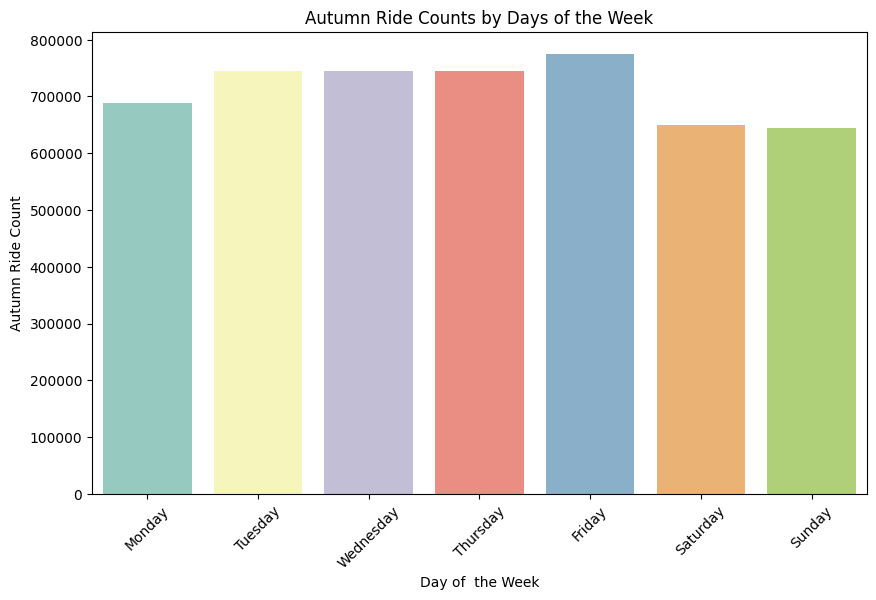

In [ ]:
#Ride count by day for spring
# Register the DataFrame as a temporary view
Autumns_df.createOrReplaceTempView("rides")

# Query the DataFrame to calculate the ride counts by day of the week
query = """
    SELECT Day, COUNT(*) AS count
    FROM rides
    GROUP BY Day
    ORDER BY Day
"""
ride_counts_pd_aut = spark.sql(query)

# Convert the resulting DataFrame to a Pandas DataFrame for plotting
ride_counts_pd_aut = ride_counts_pd_aut.toPandas()

# Define the order of the days of the week
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Set a custom color palette
colors = sns.color_palette('Set3', len(days))

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Day', y='count', data=ride_counts_pd, order=days, palette=colors)
plt.title('Autumn Ride Counts by Days of the Week')
plt.xlabel('Day of  the Week')
plt.ylabel('Autumn Ride Count')
plt.xticks(rotation=45)
plt.show()


### Hypothesis testing

In [ ]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pyspark.sql.functions as F
from scipy.stats import ttest_ind
#perform a two-sample t-test on the duration data of bike rides in spring and autumn.
sprg_dur = springs_df.select(F.col("Duration").cast("double")).rdd.flatMap(lambda x: x).collect()
autm_dur = Autumns_df.select(F.col("Duration").cast("double")).rdd.flatMap(lambda x: x).collect()

t_stat, p_value = ttest_ind(sprg_dur, autm_dur)

#print the resulting t-statistic and p-value
print("Results of Two-Sample T-Test:")
print("----------------------------")
print("T-Statistic: ", t_stat)
print("P-Value: ", p_value)

Results of Two-Sample T-Test:
----------------------------
T-Statistic:  18.30397850645596
P-Value:  7.735727006781686e-75


In [ ]:
if p_value < 0.05:
    print("Reject null hypothesis. There is sufficient evidence to conclude that autumn ride duration is greater than spring ride duration.")
else:
    print("Fail to reject null hypothesis. There is insufficient evidence to conclude that there is a significant difference between autumn and spring ride duration.")

Reject null hypothesis. There is sufficient evidence to conclude that autumn ride duration is greater than spring ride duration.


California Bike Ride

In [ ]:
# get file for given year from capitalbikeshare open data
!wget https://s3.amazonaws.com/capitalbikeshare-data/2014-capitalbikeshare-tripdata.zip
!unzip 2014-capitalbikeshare-tripdata.zip



--2023-05-26 05:57:18--  https://s3.amazonaws.com/capitalbikeshare-data/2014-capitalbikeshare-tripdata.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.94.173, 52.217.94.22, 52.216.166.93, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.94.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66499218 (63M) [application/zip]
Saving to: ‘2014-capitalbikeshare-tripdata.zip’

2014-capitalbikesha 100%[===================>]  63.42M  13.4MB/s    in 6.1s    

2023-05-26 05:57:25 (10.3 MB/s) - ‘2014-capitalbikeshare-tripdata.zip’ saved [66499218/66499218]

Archive:  2014-capitalbikeshare-tripdata.zip
  inflating: 2014Q1-capitalbikeshare-tripdata.csv  
  inflating: 2014Q2-capitalbikeshare-tripdata.csv  
  inflating: 2014Q3-capitalbikeshare-tripdata.csv  
  inflating: 2014Q4-capitalbikeshare-tripdata.csv  


In [ ]:
# MULTIPLE FILES INPUT AND ANALYSED (presuming identical schema - should test first!)
file1="./2014Q1-capitalbikeshare*csv"
file2="./2014Q2-capitalbikeshare*csv"
file3="./2014Q3-capitalbikeshare*csv"
file4="./2014Q4-capitalbikeshare*csv"
US_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load([file1, file2, file3,file4])) # i.e pass a Python list of files to load (into a single DF)


In [ ]:
US_df.show(10)

+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+
|Duration|         Start date|           End date|Start station number|       Start station|End station number|         End station|Bike number|Member type|
+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+
|     356|2014-07-01 00:01:18|2014-07-01 00:07:14|               31408|        Takoma Metro|             32011| Maple & Ritchie Ave|     W20813|     Member|
|    1097|2014-07-01 00:01:18|2014-07-01 00:19:35|               31227|13th St & New Yor...|             31512|Neal St & Trinida...|     W21178|     Member|
|     209|2014-07-01 00:02:17|2014-07-01 00:05:47|               31038|Glebe Rd & 11th St N|             31034|N Randolph St & F...|     W20902|     Member|
|     166|2014-07-01 00:02:37|2014-07-01 00:05:24|        

In [ ]:
# count the number of rows in the dataframe
num_rows = US_df.count()
print("Number of rows: ", num_rows)

# count the number of columns in the dataframe
num_cols = len(US_df.columns)
print("Number of columns: ", num_cols)

Number of rows:  2913150
Number of columns:  9


In [ ]:
US_df.columns

['Duration',
 'Start date',
 'End date',
 'Start station number',
 'Start station',
 'End station number',
 'End station',
 'Bike number',
 'Member type']

In [ ]:
#summary statistics
US_df.describe().show()

+-------+------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+
|summary|          Duration|Start station number|       Start station|End station number|         End station|Bike number|Member type|
+-------+------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+
|  count|           2913150|             2913150|             2913150|           2913150|             2913150|    2913150|    2913150|
|   mean|1033.9679882601308|  31301.073460686886|                null|31301.598708271114|                null|       null|       null|
| stddev| 1755.029515738814|  203.62170693443178|                null| 201.2666267129278|                null|       null|       null|
|    min|                60|               31000|      10th & E St NW|             31000|      10th & E St NW|     W00005|     Casual|
|    max|             86376|               32050|Wiscon

Data Wrangling

In [ ]:
#checking for duplicates value using the Bike Number
from pyspark.sql.functions import count

duplicates_USdf = US_df.groupBy("Bike number").agg(count("*").alias("count")).filter("count > 1")
duplicates_USdf.show(20)


+-----------+-----+
|Bike number|count|
+-----------+-----+
|     W21464|  896|
|     W20660|  619|
|     W20024|  435|
|     W21144|  563|
|     W20296|  490|
|     W00826|  458|
|     W21528|  676|
|     W20676|  624|
|     W00474|  678|
|     W00254|  657|
|     W21495|  172|
|     W00746|  411|
|     W21110|  567|
|     W21226|  641|
|     W20999|  680|
|     W20219|  407|
|     W00375|  567|
|     W00604|  514|
|     W01451|  325|
|     W20694|  628|
+-----------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.window import Window
#displaying the instances where the bike number is duplicated
window = Window.partitionBy("Bike number")
duplicates_USdf = US_df.withColumn("count", count("*").over(window)).filter("count > 1")
duplicates_USdf.show()


+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+-------+----------+-----+
|Duration|         Start date|           End date|Start station number|   StartStation Name|End station number|     EndStation Name|Bike number|Member type|Season|Start Month|    Day|  location|count|
+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+-------+----------+-----+
|    1461|2014-09-21 09:30:52|2014-09-21 09:55:14|               31217|USDA / 12th & Ind...|             31275|New Hampshire Ave...|     W00005|     Casual|Autumn|          9| Sunday|california|  284|
|     226|2014-09-21 11:53:57|2014-09-21 11:57:44|               31275|New Hampshire Ave...|             31224|      19th & L St NW|     W00005|     Member|Autumn|          9| Sunday|california|  

In [ ]:
#checking for missing values
from pyspark.sql.functions import col, sum as spark_sum

missing_values_count = US_df.select(*(spark_sum(col(c).isNull().cast("int")).alias(c) for c in US_df.columns)).collect()


In [ ]:
US_df.columns

['Duration',
 'Start date',
 'End date',
 'Start station number',
 'Start station',
 'End station number',
 'End station',
 'Bike number',
 'Member type']

In [ ]:
#Add the "Season" columns to the DataFrame for further analysis.
US_df = US_df.withColumn('Season', when((US_df['Start Date'] >= '2014-03-21 00:00:00') & (US_df['Start Date'] <= '2014-06-20 23:59:59'), 'Spring')
                                            .when((US_df['Start Date'] >= '2014-09-21 00:00:00') & (US_df['Start Date'] <= '2014-12-20 23:59:59'), 'Autumn')
                                            .otherwise('Other'))

In [ ]:
#filtering out rows from the DataFrame that have a season labeled as "Other".
US_df = US_df.filter(US_df['Season'] != 'Other')


In [ ]:
US_df.show()

+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+
|Duration|         Start date|           End date|Start station number|       Start station|End station number|         End station|Bike number|Member type|Season|
+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+
|     682|2014-09-21 00:00:00|2014-09-21 00:11:23|               31245|7th & R St NW / S...|             31101|      14th & V St NW|     W00750|     Member|Autumn|
|     463|2014-09-21 00:00:00|2014-09-21 00:07:44|               31101|      14th & V St NW|             31103|16th & Harvard St NW|     W20306|     Member|Autumn|
|    1176|2014-09-21 00:00:13|2014-09-21 00:19:49|               31245|7th & R St NW / S...|             31108|       4th & M St SW|     W20337|     Member|Autumn|
|     452|2014-0

In [ ]:
#Add the "Start Month" column to the DataFrame for further analysis.
US_df = US_df.withColumn('Start Month', month(US_df['Start Date']))
US_df.show()

+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+
|Duration|         Start date|           End date|Start station number|       Start station|End station number|         End station|Bike number|Member type|Season|Start Month|
+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+
|     682|2014-09-21 00:00:00|2014-09-21 00:11:23|               31245|7th & R St NW / S...|             31101|      14th & V St NW|     W00750|     Member|Autumn|          9|
|     463|2014-09-21 00:00:00|2014-09-21 00:07:44|               31101|      14th & V St NW|             31103|16th & Harvard St NW|     W20306|     Member|Autumn|          9|
|    1176|2014-09-21 00:00:13|2014-09-21 00:19:49|               31245|7th & R St NW / S...|             31108|       4t

In [ ]:
from pyspark.sql.functions import date_format
#add a column "day" representing the day of the week that corresponds to the start date
US_df = US_df.withColumn('Day', date_format('Start Date', 'EEEE'))
US_df.show()


+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+------+
|Duration|         Start date|           End date|Start station number|       Start station|End station number|         End station|Bike number|Member type|Season|Start Month|   Day|
+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+------+
|     682|2014-09-21 00:00:00|2014-09-21 00:11:23|               31245|7th & R St NW / S...|             31101|      14th & V St NW|     W00750|     Member|Autumn|          9|Sunday|
|     463|2014-09-21 00:00:00|2014-09-21 00:07:44|               31101|      14th & V St NW|             31103|16th & Harvard St NW|     W20306|     Member|Autumn|          9|Sunday|
|    1176|2014-09-21 00:00:13|2014-09-21 00:19:49|               31245|7th & R St NW 

In [ ]:
#checking for outliers (members have annual, 30-day and day key while casual have from single trip to 5 days pass)
US_filtered_df = US_df.filter(
    ((col("Duration") >= 432000.0) & (col("Member type") == "Casual")) |
    ((col("Duration") >= 31560000.0) & (col("Member type") == "Member"))
)

In [ ]:
#this means there are no outliers
US_filtered_df.show()

+--------+----------+--------+--------------------+-------------+------------------+-----------+-----------+-----------+------+-----------+---+
|Duration|Start date|End date|Start station number|Start station|End station number|End station|Bike number|Member type|Season|Start Month|Day|
+--------+----------+--------+--------------------+-------------+------------------+-----------+-----------+-----------+------+-----------+---+
+--------+----------+--------+--------------------+-------------+------------------+-----------+-----------+-----------+------+-----------+---+



In [ ]:
from pyspark.sql.functions import sum

from pyspark.sql.functions import col

# group by "StartStation Id" and sum their "Duration", sort in descending order
strt_df = (US_df
               .select("Start station", "Start station number", "End station number", "End station", "Duration")
               .groupBy("Start station number", "Start station")
               .agg(sum("Duration").alias("Total Duration"))
               .orderBy("Total Duration", ascending=False))

# show top 10
strt_df.show(10)
# group "StartStation Id" and sum their "Duration" (seconds), sort in descending order




+--------------------+--------------------+--------------+
|Start station number|       Start station|Total Duration|
+--------------------+--------------------+--------------+
|               31258|    Lincoln Memorial|      66836089|
|               31247|Jefferson Dr & 14...|      56312928|
|               31248|Smithsonian-Natio...|      44103512|
|               31200|Massachusetts Ave...|      33638807|
|               31249|  Jefferson Memorial|      28620466|
|               31623|Columbus Circle /...|      26680726|
|               31243|       4th & C St SW|      22942576|
|               31241|       Thomas Circle|      20171425|
|               31240|Ohio Dr & West Ba...|      20008816|
|               31222|New York Ave & 15...|      19751705|
+--------------------+--------------------+--------------+
only showing top 10 rows



In [ ]:
# group by "StartStation Id" and sum their "Duration", sort in descending order
end_df = (US_df
               .select("Start station", "Start station number", "End station number", "End station", "Duration")
               .groupBy("End station number", "End station")
               .agg(sum("Duration").alias("Total Duration"))
               .orderBy("Total Duration", ascending=False))

# show top 10
end_df.show(10)

+------------------+--------------------+--------------+
|End station number|         End station|Total Duration|
+------------------+--------------------+--------------+
|             31258|    Lincoln Memorial|      58628126|
|             31247|Jefferson Dr & 14...|      55902434|
|             31248|Smithsonian-Natio...|      46049447|
|             31200|Massachusetts Ave...|      33669480|
|             31623|Columbus Circle /...|      30157274|
|             31249|  Jefferson Memorial|      28788738|
|             31243|       4th & C St SW|      24059268|
|             31222|New York Ave & 15...|      23969094|
|             31215|Georgetown Harbor...|      21342023|
|             31271|Constitution Ave ...|      19773402|
+------------------+--------------------+--------------+
only showing top 10 rows



In [ ]:
from pyspark.sql.functions import hour, sum

#calculate the total duration of bike rides for each hour of the day and sort the results in descending order
df = US_df.withColumn("Start_date", to_timestamp(col("Start date")))
df = df.withColumn("Start_hour", hour(col("Start_date")))
hourly_duration = df.groupBy("Start_hour").agg(sum("Duration").alias("Total_duration"))
hourly_duration = hourly_duration.orderBy(hourly_duration["Total_duration"].desc())






Data Visualisation

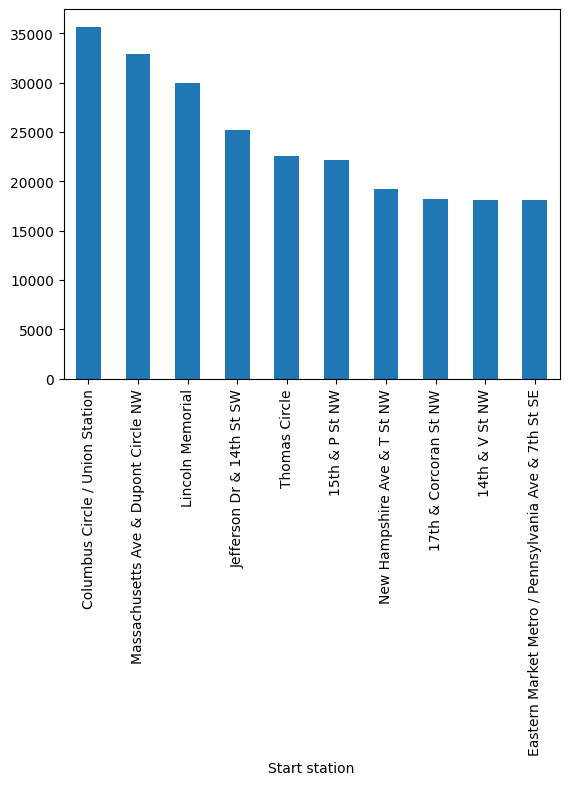

In [ ]:
# Group by location and count the number of occurrences
StartStation_counts = US_df.groupby("Start station").count()

# Order by count in descending order and select the top 10 locations
top10_StartStations = StartStation_counts.orderBy("count", ascending=False).limit(10)

# Convert the resulting DataFrame to a Pandas DataFrame
top10_StartStation_pandas = top10_StartStations.toPandas()

# Plot a bar chart of the top 10 locations
top10_StartStation_pandas.plot(kind="bar", x="Start station", y="count", legend=False);

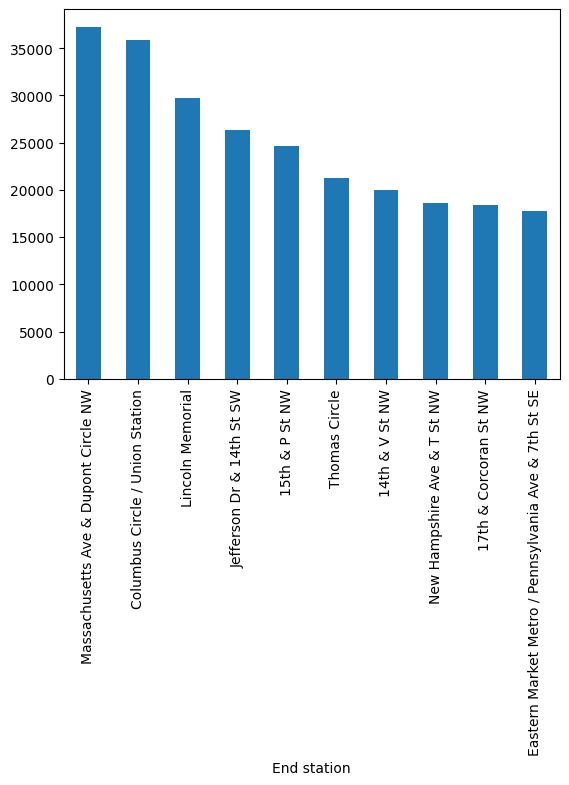

In [ ]:
# Group by location and count the number of occurrences
EndStation_counts = US_df.groupby("End station").count()

# Order by count in descending order and select the top 10 locations
top10_EndStations = EndStation_counts.orderBy("count", ascending=False).limit(10)

# Convert the resulting DataFrame to a Pandas DataFrame
top10_EndStation_pandas = top10_EndStations.toPandas()

# Plot a bar chart of the top 10 locations
top10_EndStation_pandas.plot(kind="bar", x="End station", y="count", legend=False);

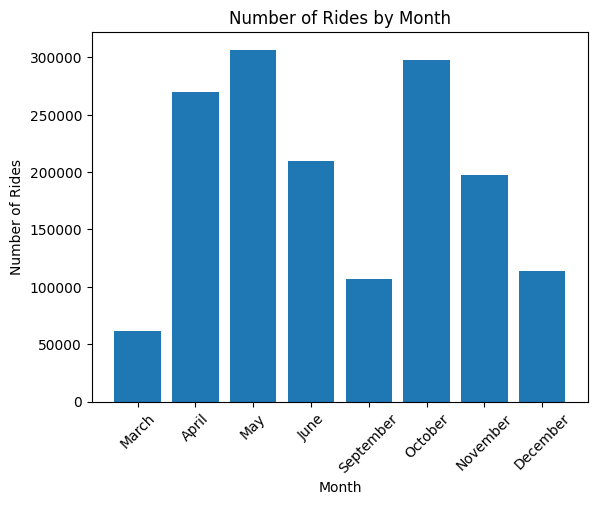

In [ ]:
import matplotlib.pyplot as plt
import calendar

# Group by month and count the number of rides
counts = US_df.groupBy("Start Month").count().orderBy("Start Month")

# Extract the month numbers and counts as lists
months = [row["Start Month"] for row in counts.collect()]
count_values = [row["count"] for row in counts.collect()]

# Convert month numbers to month names
month_names = [calendar.month_name[month_num] for month_num in months]

# Create a bar chart using matplotlib
plt.bar(month_names, count_values)
plt.title("Number of Rides by Month")
plt.xlabel("Month")
plt.ylabel("Number of Rides")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.show()


<Axes: xlabel='season'>

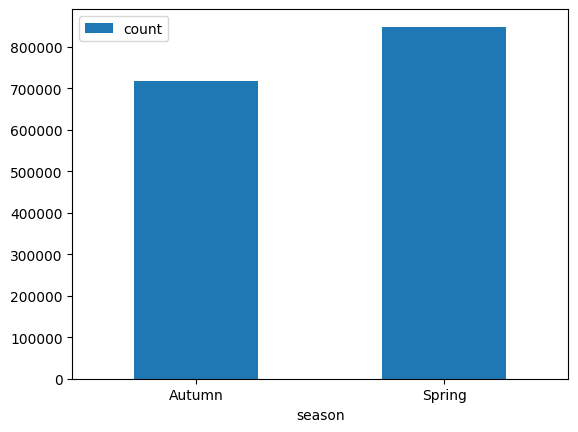

In [ ]:
# group the data by season and count the number of rentals in each season
season_counts_df = US_df.groupBy('season').count()

# plot a bar chart of the rental counts by season
season_counts_df.toPandas().plot(kind='bar', x='season', y='count', rot=0)

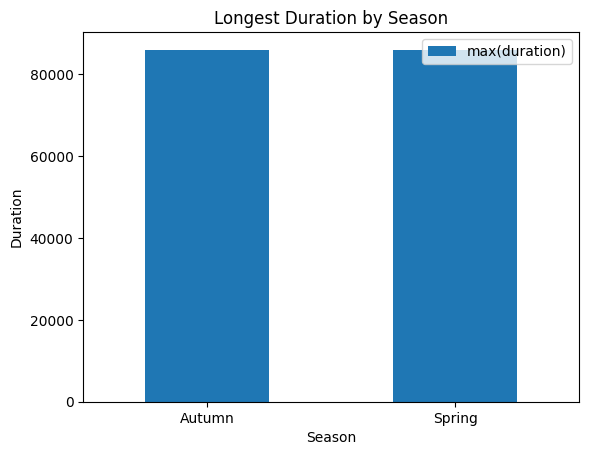

In [ ]:
# Group the data by season and find the maximum duration in each season
season_max_duration_df = US_df.groupBy('season').max('duration')

# Plot a bar chart of the maximum duration by season
season_max_duration_df.toPandas().plot(kind='bar', x='season', y='max(duration)', rot=0)

# Set the axis labels and title
plt.title("Longest Duration by Season")
plt.xlabel("Season")
plt.ylabel("Duration")
plt.show()


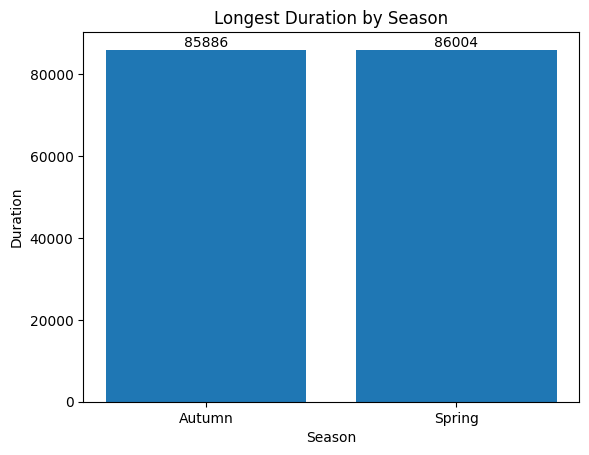

In [ ]:
import numpy as np

# Get the data from the DataFrame
season_max_duration_data = season_max_duration_df.toPandas()

# Plot a bar chart with value annotations
fig, ax = plt.subplots()
bars = ax.bar(season_max_duration_data['season'], season_max_duration_data['max(duration)'])
ax.set_xlabel("Season")
ax.set_ylabel("Duration")
ax.set_title("Longest Duration by Season")

# Add value annotations to the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, str(int(yval)), ha='center', va='bottom')

plt.show()


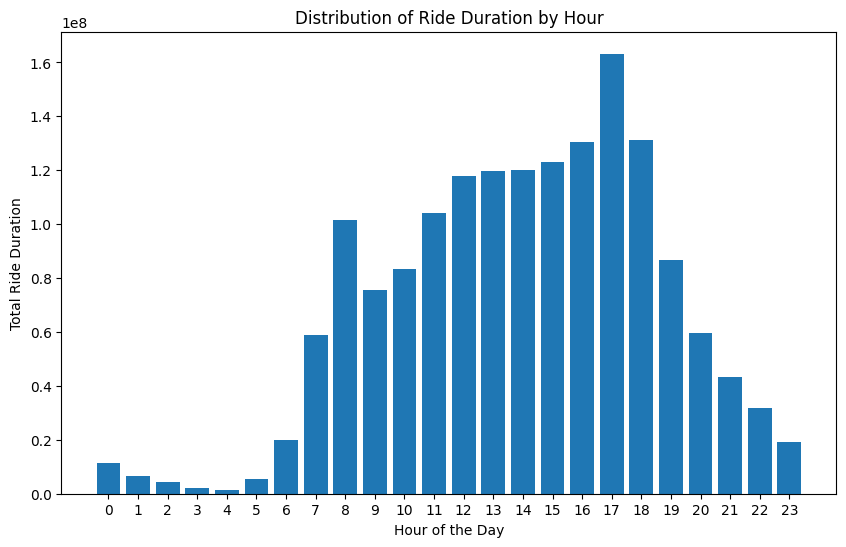

In [ ]:
import matplotlib.pyplot as plt

# Convert "Start date" column to timestamp
df = US_df.withColumn("Start_date", to_timestamp(col("Start date")))

# Extract the hour from "Start_date" column
df = df.withColumn("Start_hour", hour(col("Start_date")))

# Group by "Start_hour" and calculate sum of ride durations
hourly_duration = df.groupBy("Start_hour").agg(sum("Duration").alias("Total_duration"))

# Sort by "Start_hour"
hourly_duration = hourly_duration.orderBy("Start_hour")

# Extract the hour and total duration columns
hours = [row["Start_hour"] for row in hourly_duration.collect()]
total_durations = [row["Total_duration"] for row in hourly_duration.collect()]

# Plot the distribution of ride duration by hour
plt.figure(figsize=(10, 6))
plt.bar(hours, total_durations)
plt.xlabel("Hour of the Day")
plt.ylabel("Total Ride Duration")
plt.title("Distribution of Ride Duration by Hour")
plt.xticks(hours)
plt.show()


In [ ]:
US_sprg= US_df.filter(US_df.Season == "Spring")
US_autm= US_df.filter(US_df.Season == "Autumn")

In [ ]:
US_sprg.show()

+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+-------+
|Duration|         Start date|           End date|Start station number|       Start station|End station number|         End station|Bike number|Member type|Season|Start Month|    Day|
+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+-------+
|     669|2014-04-01 00:00:01|2014-04-01 00:11:11|               31600|       5th & K St NW|             31628|       1st & K St SE|     W21189|     Member|Spring|          4|Tuesday|
|     242|2014-04-01 00:02:15|2014-04-01 00:06:18|               31017|Wilson Blvd & N U...|             31019|Wilson Blvd & N E...|     W00345|     Member|Spring|          4|Tuesday|
|     335|2014-04-01 00:02:48|2014-04-01 00:08:24|               31610|Eastern M

In [ ]:
US_autm.show()

+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+------+
|Duration|         Start date|           End date|Start station number|       Start station|End station number|         End station|Bike number|Member type|Season|Start Month|   Day|
+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+------+
|     682|2014-09-21 00:00:00|2014-09-21 00:11:23|               31245|7th & R St NW / S...|             31101|      14th & V St NW|     W00750|     Member|Autumn|          9|Sunday|
|     463|2014-09-21 00:00:00|2014-09-21 00:07:44|               31101|      14th & V St NW|             31103|16th & Harvard St NW|     W20306|     Member|Autumn|          9|Sunday|
|    1176|2014-09-21 00:00:13|2014-09-21 00:19:49|               31245|7th & R St NW 

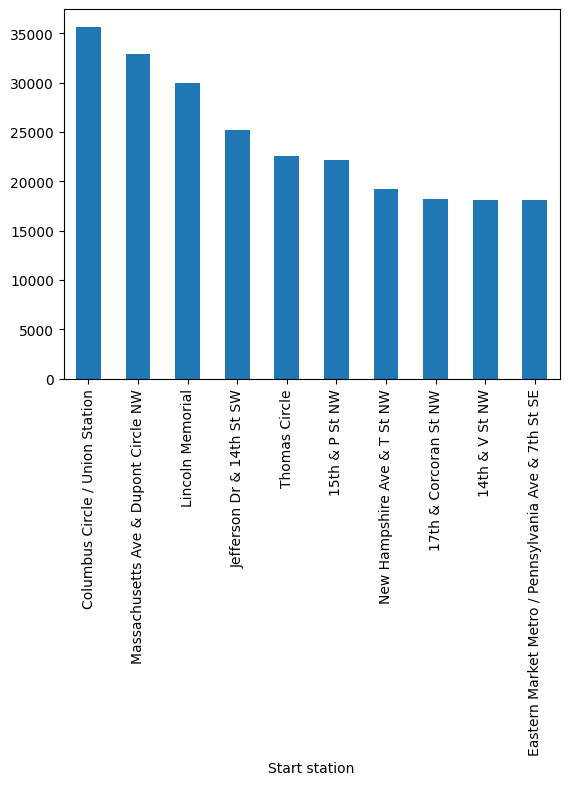

In [ ]:
# Group by location and count the number of occurrences
StartStation_count = US_df.groupby("Start station").count()

# Order by count in descending order and select the top 10 locations
top10_StartStation = StartStation_count.orderBy("count", ascending=False).limit(10)

# Convert the resulting DataFrame to a Pandas DataFrame
top10_StartStation_pandas = top10_StartStation.toPandas()

# Plot a bar chart of the top 10 locations
top10_StartStation_pandas.plot(kind="bar", x="Start station", y="count", legend=False);

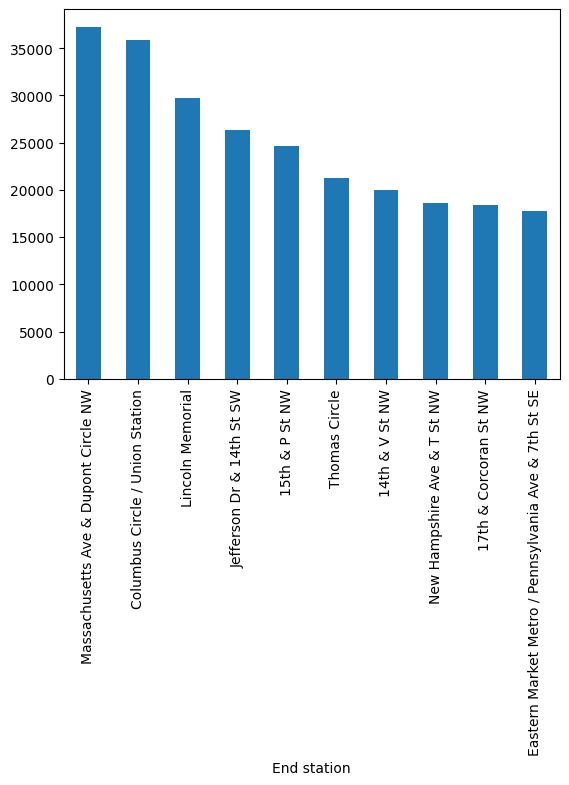

In [ ]:
# Group by location and count the number of occurrences
Destination_count = US_df.groupby("End station").count()

# Order by count in descending order and select the top 10 locations
top10_Destination = Destination_count.orderBy("count", ascending=False).limit(10)

# Convert the resulting DataFrame to a Pandas DataFrame
top10_Destination_pandas = top10_Destination.toPandas()

# Plot a bar chart of the top 10 locations
top10_Destination_pandas.plot(kind="bar", x="End station", y="count", legend=False);

In [ ]:
# group by month and count the number of rides
counts = US_df.groupBy("Start month").count()

# sort the counts in descending order and select the first row
most_traveled_month = counts.orderBy(counts["count"].desc()).first()["Start month"]

# print the result
print("The most traveled month is", most_traveled_month)


The most traveled month is 5


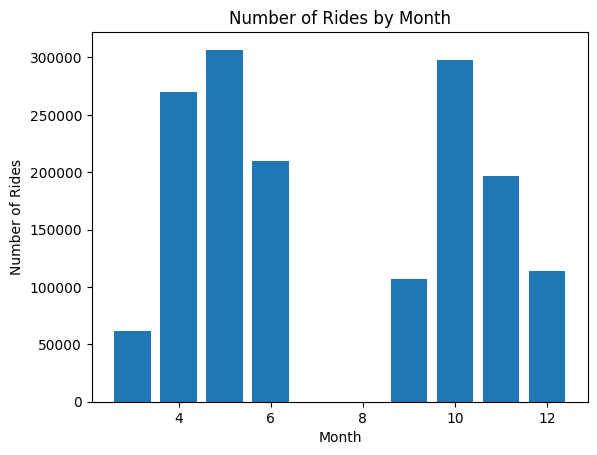

In [ ]:
# Group by month and count the number of rides
counts = US_df.groupby("Start month").count().orderBy("Start month").toPandas()
# Extract the month names and counts as lists
months = counts["Start month"].tolist()
count_values = counts["count"].tolist()

# Create a bar chart using matplotlib
plt.bar(months, count_values)
plt.title("Number of Rides by Month")
plt.xlabel("Month")
plt.ylabel("Number of Rides")
plt.show()

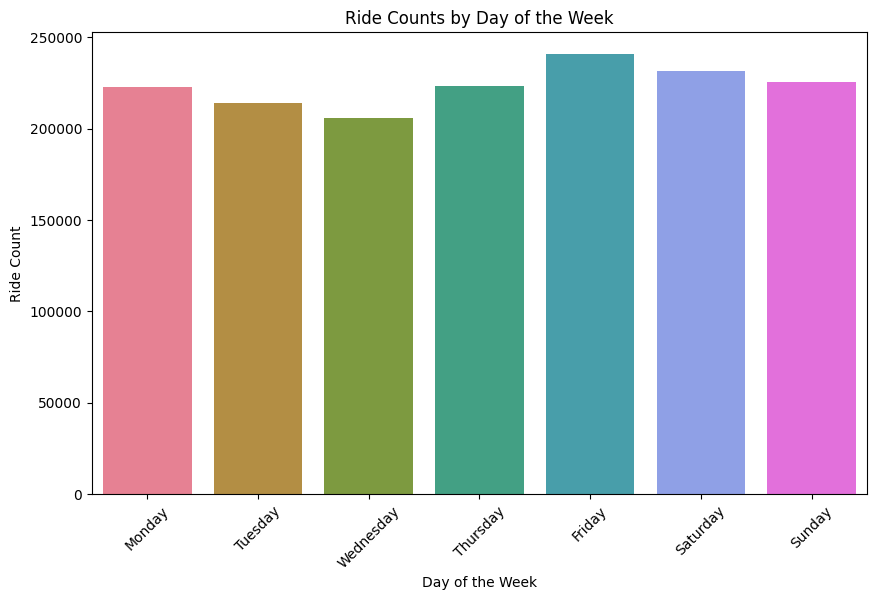

In [ ]:
import seaborn as sns
# Group the DataFrame by 'Weekday' and count the number of rides
ride_counts = US_df.groupBy('Day').count().orderBy('Day')

# Convert the resulting DataFrame to a Pandas DataFrame for plotting
ride_counts_pd = ride_counts.toPandas()

# Define the order of the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Set a custom color palette
colors = sns.color_palette('husl', len(days_order))

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Day', y='count', data=ride_counts_pd, order=days_order, palette=colors)
plt.title('Ride Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Ride Count')
plt.xticks(rotation=45)
plt.show()



In [ ]:
sprg = US_df.filter(US_df.Season == "Spring")
sprg.show(10)

+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+-------+
|Duration|         Start date|           End date|Start station number|       Start station|End station number|         End station|Bike number|Member type|Season|Start Month|    Day|
+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+-------+
|     669|2014-04-01 00:00:01|2014-04-01 00:11:11|               31600|       5th & K St NW|             31628|       1st & K St SE|     W21189|     Member|Spring|          4|Tuesday|
|     242|2014-04-01 00:02:15|2014-04-01 00:06:18|               31017|Wilson Blvd & N U...|             31019|Wilson Blvd & N E...|     W00345|     Member|Spring|          4|Tuesday|
|     335|2014-04-01 00:02:48|2014-04-01 00:08:24|               31610|Eastern M

In [ ]:
sprg.count()

847917

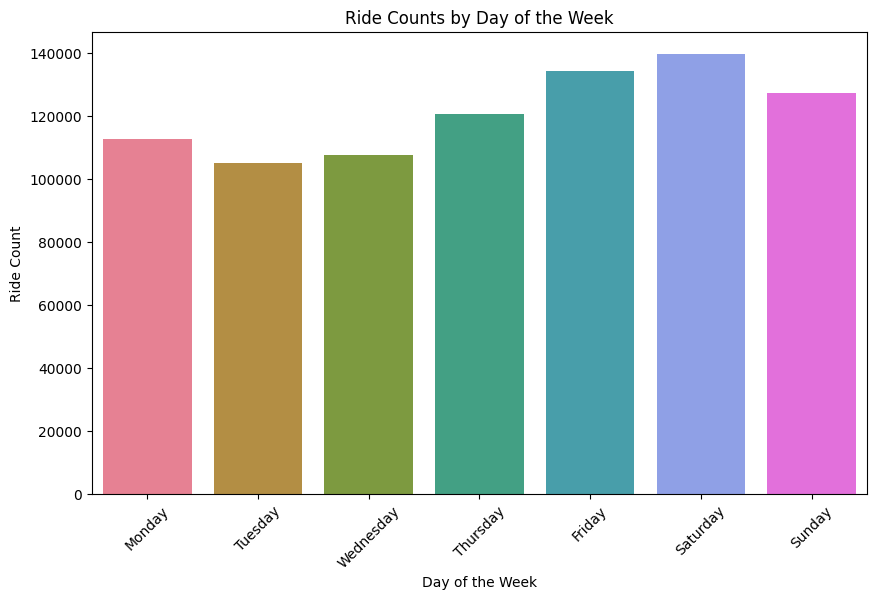

In [ ]:
# Group the DataFrame by 'Weekday' and count the number of rides
sprg_ride_counts = sprg.groupBy('Day').count().orderBy('Day')

# Convert the resulting DataFrame to a Pandas DataFrame for plotting
sprg_ride_counts_pd = sprg_ride_counts.toPandas()

# Define the order of the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Set a custom color palette
colors = sns.color_palette('husl', len(days_order))

# Create a bar plot with colorful bars
plt.figure(figsize=(10, 6))
sns.barplot(x='Day', y='count', data=sprg_ride_counts_pd, order=days_order, palette=colors)
plt.title('Ride Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Ride Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
Aut = US_df.filter(US_df.Season == "Autumn")
Aut.show(10)

+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+------+
|Duration|         Start date|           End date|Start station number|       Start station|End station number|         End station|Bike number|Member type|Season|Start Month|   Day|
+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+------+
|     682|2014-09-21 00:00:00|2014-09-21 00:11:23|               31245|7th & R St NW / S...|             31101|      14th & V St NW|     W00750|     Member|Autumn|          9|Sunday|
|     463|2014-09-21 00:00:00|2014-09-21 00:07:44|               31101|      14th & V St NW|             31103|16th & Harvard St NW|     W20306|     Member|Autumn|          9|Sunday|
|    1176|2014-09-21 00:00:13|2014-09-21 00:19:49|               31245|7th & R St NW 

In [ ]:
Aut.count()

716204

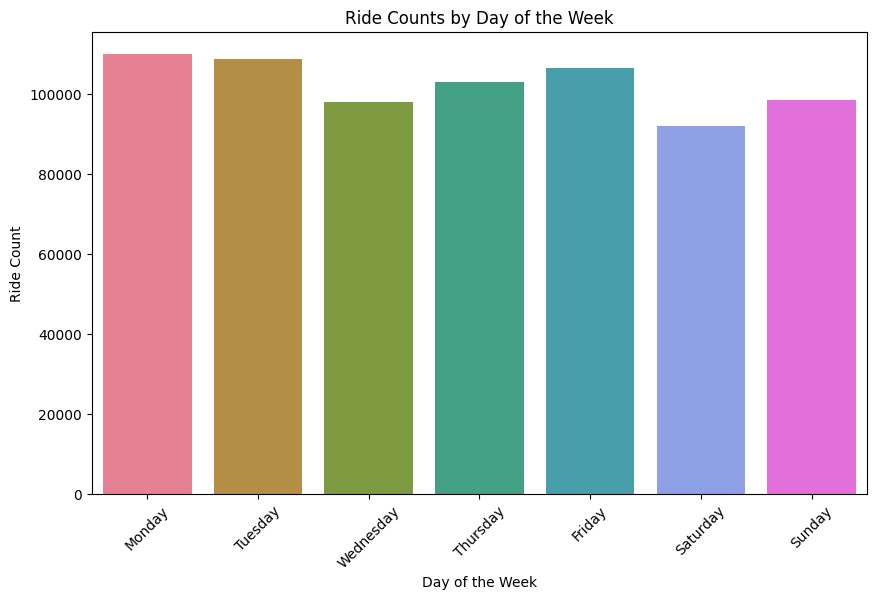

In [ ]:
# Group the DataFrame by 'Weekday' and count the number of rides
Aut_ride_counts = Aut.groupBy('Day').count().orderBy('Day')

# Convert the resulting DataFrame to a Pandas DataFrame for plotting
Aut_ride_counts_pd = Aut_ride_counts.toPandas()

# Define the order of the days of the week
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Set a custom color palette
colors = sns.color_palette('husl', len(days_order))

# Create a bar plot with colorful bars
plt.figure(figsize=(10, 6))
sns.barplot(x='Day', y='count', data=Aut_ride_counts_pd, order=days_order, palette=colors)
plt.title('Ride Counts by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Ride Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
#add a new column 'location' with the value 'california' to the US_df dataframe
US_df=US_df.withColumn('location', lit('california'))
US_df.show()

+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+------+----------+
|Duration|         Start date|           End date|Start station number|       Start station|End station number|         End station|Bike number|Member type|Season|Start Month|   Day|  location|
+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+------+----------+
|     682|2014-09-21 00:00:00|2014-09-21 00:11:23|               31245|7th & R St NW / S...|             31101|      14th & V St NW|     W00750|     Member|Autumn|          9|Sunday|california|
|     463|2014-09-21 00:00:00|2014-09-21 00:07:44|               31101|      14th & V St NW|             31103|16th & Harvard St NW|     W20306|     Member|Autumn|          9|Sunday|california|
|    1176|2014-09-21 00:00:13|

In [ ]:
journey_df.show()

+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|Start Month|Season|   Day|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+------+
| 37875851|     120|   3229|2014-09-28 00:02:00|          450|Jubilee Street, S...|2014-09-28 00:00:00|            443|Philpot Street, W...|          9|Autumn|Sunday|
| 37875861|    1080|   3283|2014-09-28 00:18:00|          645|Great Suffolk Str...|2014-09-28 00:00:00|             14|Belgrove Street ,...|          9|Autumn|Sunday|
| 37875857|    2820|  11369|2014-09-28 00:47:00|          727|Chesilton Road, F...|2014-09-28 00:00:00|            321|Bermondsey Street...|          9|Autumn|Sunday

In [ ]:
#add a new column 'location' with the value 'London' to the journey_df dataframe
journey_df=journey_df.withColumn('location', lit('London'))
journey_df.show()

+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+------+--------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|Start Month|Season|   Day|location|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----------+------+------+--------+
| 37875851|     120|   3229|2014-09-28 00:02:00|          450|Jubilee Street, S...|2014-09-28 00:00:00|            443|Philpot Street, W...|          9|Autumn|Sunday|  London|
| 37875861|    1080|   3283|2014-09-28 00:18:00|          645|Great Suffolk Str...|2014-09-28 00:00:00|             14|Belgrove Street ,...|          9|Autumn|Sunday|  London|
| 37875857|    2820|  11369|2014-09-28 00:47:00|          727|Chesilton Road, F...|2014-09-28 00:00:00|            321|B

In [ ]:
#select specific columns from the journey_df dataframe and create a new dataframe 
a_df=journey_df.select ('Duration','End Date','EndStation Name','Start Date','StartStation Name','Season', 'location')
a_df.show()

+--------+-------------------+--------------------+-------------------+--------------------+------+--------+
|Duration|           End Date|     EndStation Name|         Start Date|   StartStation Name|Season|location|
+--------+-------------------+--------------------+-------------------+--------------------+------+--------+
|     120|2014-09-28 00:02:00|Jubilee Street, S...|2014-09-28 00:00:00|Philpot Street, W...|Autumn|  London|
|    1080|2014-09-28 00:18:00|Great Suffolk Str...|2014-09-28 00:00:00|Belgrove Street ,...|Autumn|  London|
|    2820|2014-09-28 00:47:00|Chesilton Road, F...|2014-09-28 00:00:00|Bermondsey Street...|Autumn|  London|
|    1620|2014-09-28 00:27:00|Victoria Park Roa...|2014-09-28 00:00:00|Tallis Street, Te...|Autumn|  London|
|     480|2014-09-28 00:08:00|Regent's Row , Ha...|2014-09-28 00:00:00|Dunston Road , Ha...|Autumn|  London|
|    1080|2014-09-28 00:18:00|    Furze Green, Bow|2014-09-28 00:00:00|Royal London Hosp...|Autumn|  London|
|    1380|2014-09-2

In [ ]:
#Rename columns
US_df = US_df.withColumnRenamed("End station", "EndStation Name").withColumnRenamed("Start station", "StartStation Name")

In [ ]:
US_df.show()

+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+------+----------+
|Duration|         Start date|           End date|Start station number|   StartStation Name|End station number|     EndStation Name|Bike number|Member type|Season|Start Month|   Day|  location|
+--------+-------------------+-------------------+--------------------+--------------------+------------------+--------------------+-----------+-----------+------+-----------+------+----------+
|     682|2014-09-21 00:00:00|2014-09-21 00:11:23|               31245|7th & R St NW / S...|             31101|      14th & V St NW|     W00750|     Member|Autumn|          9|Sunday|california|
|     463|2014-09-21 00:00:00|2014-09-21 00:07:44|               31101|      14th & V St NW|             31103|16th & Harvard St NW|     W20306|     Member|Autumn|          9|Sunday|california|
|    1176|2014-09-21 00:00:13|

In [ ]:
a_df.show()

+--------+-------------------+--------------------+-------------------+--------------------+------+--------+
|Duration|           End Date|     EndStation Name|         Start Date|   StartStation Name|Season|location|
+--------+-------------------+--------------------+-------------------+--------------------+------+--------+
|     120|2014-09-28 00:02:00|Jubilee Street, S...|2014-09-28 00:00:00|Philpot Street, W...|Autumn|  London|
|    1080|2014-09-28 00:18:00|Great Suffolk Str...|2014-09-28 00:00:00|Belgrove Street ,...|Autumn|  London|
|    2820|2014-09-28 00:47:00|Chesilton Road, F...|2014-09-28 00:00:00|Bermondsey Street...|Autumn|  London|
|    1620|2014-09-28 00:27:00|Victoria Park Roa...|2014-09-28 00:00:00|Tallis Street, Te...|Autumn|  London|
|     480|2014-09-28 00:08:00|Regent's Row , Ha...|2014-09-28 00:00:00|Dunston Road , Ha...|Autumn|  London|
|    1080|2014-09-28 00:18:00|    Furze Green, Bow|2014-09-28 00:00:00|Royal London Hosp...|Autumn|  London|
|    1380|2014-09-2

In [ ]:
#selects specific columns from the US_df dataframe and creates a new dataframe 
b_df = US_df.select('Duration','End Date','EndStation Name','Start date','StartStation Name','Season','location')
b_df.show(10)

+--------+-------------------+--------------------+-------------------+--------------------+------+----------+
|Duration|           End Date|     EndStation Name|         Start date|   StartStation Name|Season|  location|
+--------+-------------------+--------------------+-------------------+--------------------+------+----------+
|     682|2014-09-21 00:11:23|      14th & V St NW|2014-09-21 00:00:00|7th & R St NW / S...|Autumn|california|
|     463|2014-09-21 00:07:44|16th & Harvard St NW|2014-09-21 00:00:00|      14th & V St NW|Autumn|california|
|    1176|2014-09-21 00:19:49|       4th & M St SW|2014-09-21 00:00:13|7th & R St NW / S...|Autumn|california|
|     452|2014-09-21 00:07:47|       5th & K St NW|2014-09-21 00:00:14|      11th & M St NW|Autumn|california|
|     199|2014-09-21 00:04:31|California St & F...|2014-09-21 00:01:11|      14th & V St NW|Autumn|california|
|    1354|2014-09-21 00:23:49|  Jefferson Memorial|2014-09-21 00:01:15|    Lincoln Memorial|Autumn|california|
|

In [ ]:
#join the new dataframe from journey_df and US_df using union
j_df = a_df.union(b_df)
j_df.show(5)

+--------+-------------------+--------------------+-------------------+--------------------+------+--------+
|Duration|           End Date|     EndStation Name|         Start Date|   StartStation Name|Season|location|
+--------+-------------------+--------------------+-------------------+--------------------+------+--------+
|     120|2014-09-28 00:02:00|Jubilee Street, S...|2014-09-28 00:00:00|Philpot Street, W...|Autumn|  London|
|    1080|2014-09-28 00:18:00|Great Suffolk Str...|2014-09-28 00:00:00|Belgrove Street ,...|Autumn|  London|
|    2820|2014-09-28 00:47:00|Chesilton Road, F...|2014-09-28 00:00:00|Bermondsey Street...|Autumn|  London|
|    1620|2014-09-28 00:27:00|Victoria Park Roa...|2014-09-28 00:00:00|Tallis Street, Te...|Autumn|  London|
|     480|2014-09-28 00:08:00|Regent's Row , Ha...|2014-09-28 00:00:00|Dunston Road , Ha...|Autumn|  London|
+--------+-------------------+--------------------+-------------------+--------------------+------+--------+
only showing top 5 

In [ ]:
j_df.count()

6556138

In [ ]:
spark = SparkSession.builder.config("spark.driver.memory", "8g").getOrCreate()


Text(0, 0.5, 'Location')

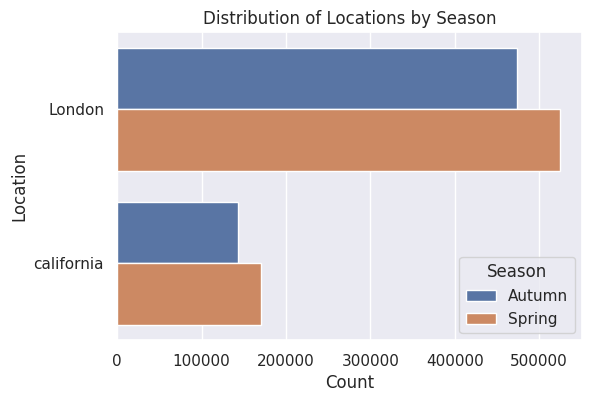

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a Pandas DataFrame from the joined Spark DataFrame
BD_sample = j_df.select("location", "Season").sample(fraction=0.2, seed=42)
BD_pd = BD_sample.toPandas()

# Plot the distribution of locations by season using seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(6, 4))
sns.countplot(data=BD_pd, y="location", hue="Season")
plt.title("Distribution of Locations by Season")
plt.xlabel("Count")
plt.ylabel("Location")


In [ ]:
from pyspark.sql.functions import mean

# Calculate the mean duration by location and season
loc_season_mean_dur = j_df.groupBy("location", "Season").agg(mean("Duration").alias("mean_duration"))

# Convert the Spark DataFrame to a Pandas DataFrame for visualization
meandur_pd = loc_season_mean_dur.toPandas()


In [ ]:
# Calculate the mean duration by location and season
loc_season_mean_dur = j_df.groupBy("location", "Season").agg(mean("Duration").alias("mean_duration"))

# Convert the Spark DataFrame to a Pandas DataFrame for visualization
meandur_pd = loc_season_mean_dur.toPandas()


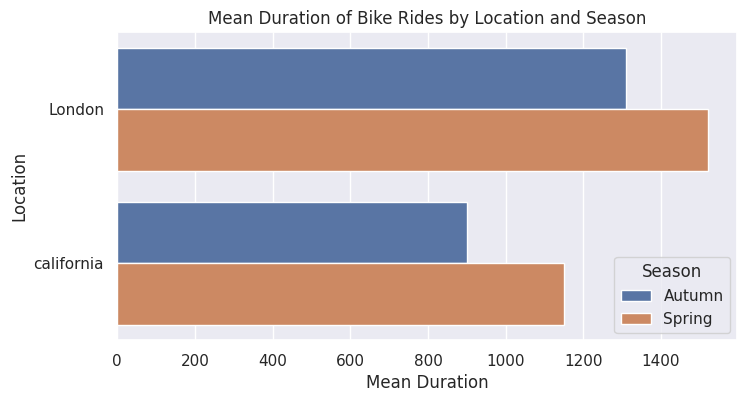

In [ ]:
# Plot the mean duration by location and season using seaborn
sns.set(style="darkgrid")
plt.figure(figsize=(8, 4))
sns.barplot(data=meandur_pd, x="mean_duration", y="location", hue="Season")
plt.title("Mean Duration of Bike Rides by Location and Season")
plt.xlabel("Mean Duration")
plt.ylabel("Location")
plt.legend(title="Season")
plt.show()


In [ ]:
from scipy import stats

In [ ]:
# Print the schema of the DataFrame to check the data types
j_df.printSchema()


root
 |-- Duration: long (nullable = true)
 |-- End Date: timestamp (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: timestamp (nullable = true)
 |-- StartStation Name: string (nullable = true)
 |-- Season: string (nullable = false)
 |-- location: string (nullable = false)



In [ ]:
meandur_pd

,location,Season,mean_duration
0,London,Autumn,1310.117776
1,London,Spring,1520.429688
2,california,Autumn,900.351534
3,california,Spring,1151.235583


In [ ]:
spring_london_mean_duration = meandur_pd.loc[(meandur_pd["location"] == "London") & (meandur_pd["Season"] == "Spring"), "mean_duration"].values
spring_california_mean_duration = meandur_pd.loc[(meandur_pd["location"] == "california") & (meandur_pd["Season"] == "Spring"), "mean_duration"].values

if len(spring_london_mean_duration) > 0 and len(spring_california_mean_duration) > 0:
    if spring_london_mean_duration[0] > spring_california_mean_duration[0]:
        print("The duration of spring bike rides in London is greater than in California")
    else:
        print("The duration of spring bike rides in California is greater than in London")
else:
    print("No data available for the specified condition")


The duration of spring bike rides in London is greater than in California


In [ ]:
spring_london_mean_duration = meandur_pd.loc[(meandur_pd["location"] == "London") & (meandur_pd["Season"] == "Spring"), "mean_duration"].values[0]
spring_california_mean_duration = meandur_pd.loc[(meandur_pd["location"] == "california") & (meandur_pd["Season"] == "Spring"), "mean_duration"].values[0]

if spring_london_mean_duration > spring_california_mean_duration:
    print("The duration of spring bike rides in London is greater than in California")
else:
    print("The duration of spring bike rides in California is greater than in London")


The duration of spring bike rides in London is greater than in California


In [ ]:
from pyspark.sql.functions import col
from scipy.stats import ttest_ind
from pyspark.sql.functions import mean
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [ ]:
#perform a two-sample t-test on the duration data of bike rides in spring and autumn.
spring_london_dur = j_df.filter((j_df.location == "London") & (j_df.Season == "Spring")).select("Duration").toPandas()
spring_california_dur = j_df.filter((j_df.location == "california") & (j_df.Season == "Spring")).select("Duration").toPandas()

t_statistic, p_value = stats.ttest_ind(spring_london_dur, spring_california_dur)

print("T-test statistic:", t_statistic)
print("P-value:", p_value)

alpha = 0.05  # Significance level
#print the resulting t-statistic and p-value
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in the mean duration of spring rides between London and California")
else:
    print("Accept the null hypothesis: There is no significant difference in the mean duration of spring rides between London and California")


T-test statistic: [27.00605511]
P-value: [1.30377993e-160]
Reject the null hypothesis: There is a significant difference in the mean duration of spring rides between London and California
